In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider
import time
import os
import h5py as h5
import time
from IPython.display import HTML


In [31]:

start_time = time.time()

# Constants
# G = 6.67430e-11  # Gravitational constant
# c = 3.0e8        # Speed of light
# M = 1.0e30       # Mass of the black hole (in kg)
c, G = 1, 1
M = 1
rs = 2 * G * M / c**2  # Schwarzschild radius

sky_rad = 70*rs
NS_rad = 10*rs
BH_vis_rad = 0.5*rs

image_width, image_height = 160,120
traj_dir  = os.getcwd() + '/trajectories/'
traj_filename = 'traj' + '_w' + str(image_width) + '_h' + str(image_height) + '.h5'

# camera is located at (20, +/-0.01,+/-0.01)rs 
traj_x, traj_y, traj_z = read_trajectories(traj_dir + traj_filename)

import random
# Generate random stars on the background shell
def generate_stars(num_stars, sky_rad):
    star_pos = np.zeros((num_stars,3))
    star_size = np.zeros(num_stars)
    for i in range(num_stars):
        theta = random.uniform(0, 2 * np.pi)
        phi = random.uniform(0, np.pi)
        x = sky_rad*np.sin(phi) * np.cos(theta)
        y = sky_rad*np.sin(phi) * np.sin(theta)
        z = sky_rad*np.cos(phi)
        star_size[i] = 10**random.uniform(-10, -4)  # Random size for the star
        # star_size[i] = 10**random.uniform(-6, -4)  # Random size for the star
        star_pos[i]  = np.array([x,y,z])
    return star_pos, star_size

num_stars = 5000
star_pos, star_size = generate_stars(num_stars,sky_rad)



In [32]:



def read_trajectories(traj_filename):
    with h5.File(traj_filename, 'r') as f:
        traj_x = f['traj_x'][:]
        traj_y = f['traj_y'][:]
        traj_z = f['traj_z'][:]
    return traj_x, traj_y, traj_z

def hit_ns(traj_x, traj_y, traj_z, ns_pos, ns_rad):
    # Calculate the distance from each point to the neutron star position
    distances = np.sqrt((traj_x - ns_pos[0])**2 + (traj_y - ns_pos[1])**2 + (traj_z - ns_pos[2])**2)
    
    # Determine if the distance is smaller than the neutron star radius
    hits = distances < ns_rad
    
    return hits

def hit_sky(traj_x, traj_y, traj_z, sky_pos, sky_rad):
    # Calculate the distance from each point to the neutron star position
    distances = np.sqrt((traj_x - sky_pos[0])**2 + (traj_y - sky_pos[1])**2 + (traj_z - sky_pos[2])**2)
    
    # Determine if the distance is smaller than the neutron star radius
    hits = distances > sky_rad
    return hits

arr_size = 50
NS_pos_the_arr = np.pi/2*90/90 * np.ones(arr_size)
NS_pos_phi_arr = np.linspace(np.pi *4/6, np.pi*8/6, arr_size)
NS_pos_rad_arr = 50*rs * np.ones(arr_size)
NS_pos_arr = np.array([NS_pos_rad_arr*np.sin(NS_pos_the_arr) * np.cos(NS_pos_phi_arr),
                        NS_pos_rad_arr*np.sin(NS_pos_the_arr) * np.sin(NS_pos_phi_arr),
                        NS_pos_rad_arr*np.cos(NS_pos_the_arr)])

images = []
for NS_pos in NS_pos_arr.T:
    print(NS_pos)


    hits_bh = hit_ns(traj_x, traj_y, traj_z, np.array([0,0,0]), BH_vis_rad)
    hits_ns = hit_ns(traj_x, traj_y, traj_z, NS_pos, NS_rad)
    hits_sky = hit_sky(traj_x, traj_y, traj_z, np.array([0,0,0]), sky_rad)

    BH_mask  = np.any(hits_bh, axis=-1)
    NS_mask  = np.any(hits_ns, axis=-1) * (1-BH_mask)
    sky_mask = np.any(hits_sky, axis=-1) * (1-BH_mask) * (1-NS_mask)
    NS_first_hit  = np.argmax(hits_ns , axis=-1)
    sky_first_hit = np.argmax(hits_sky, axis=-1)

    NS_hit_x = traj_x[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit]
    NS_hit_y = traj_y[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit]
    NS_hit_z = traj_z[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit]

    sky_hit_x = traj_x[np.arange(image_width)[:, None],np.arange(image_height),sky_first_hit]
    sky_hit_y = traj_y[np.arange(image_width)[:, None],np.arange(image_height),sky_first_hit]
    sky_hit_z = traj_z[np.arange(image_width)[:, None],np.arange(image_height),sky_first_hit]

    NS_hit_vx = NS_hit_x - traj_x[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit-1]
    NS_hit_vy = NS_hit_y - traj_y[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit-1]
    NS_hit_vz = NS_hit_z - traj_z[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit-1]

    NS_hit_nx = NS_hit_x - NS_pos[0]
    NS_hit_ny = NS_hit_y - NS_pos[1]
    NS_hit_nz = NS_hit_z - NS_pos[2]

    NS_intensity = - (NS_hit_vx * NS_hit_nx + NS_hit_vy * NS_hit_ny + NS_hit_vz * NS_hit_nz)\
            /(np.sqrt(NS_hit_vx**2 + NS_hit_vy**2 + NS_hit_vz**2)+1e-15)\
            /(np.sqrt(NS_hit_nx**2 + NS_hit_ny**2 + NS_hit_nz**2+1e-15))

    print("Step 2: NS and sky hit cleared")


    sky_hit_pos = np.stack((sky_hit_x,sky_hit_y,sky_hit_z),axis=-1)
    hit_star_all = np.zeros((image_width,image_height,num_stars))
    for i in range(num_stars):
        cos_angle = np.dot(sky_hit_pos,star_pos[i,:]) / (sky_rad*np.sqrt(np.sum(sky_hit_pos**2,axis=-1)))
        hit_star_all[:,:,i] = cos_angle > (1-star_size[i])

    star_mask = np.any(hit_star_all,axis=-1)

    print("Step 3: Stars hit cleared")

    final_color = np.zeros((image_width,image_height,3))
    NS_color_dark     = np.array([60, 90, 255])/255
    NS_color_bright   = np.array([255, 255, 255])/255
    BH_color   = np.array([0,0,0])
    star_color = np.array([1,1,1])
    final_color = NS_color_bright * NS_intensity[...,None] * NS_mask[...,None] \
                + NS_color_dark * NS_mask[...,None] * (1-NS_intensity[...,None]) \
                + BH_color * BH_mask[...,None] \
                + star_color * star_mask[...,None] * sky_mask[...,None] 

    image = np.transpose(final_color, (1, 0, 2))
    images.append(image)

# print("Step 4: Image saved")
# fig.savefig(os.getcwd()+"/bh3d_local.png",bbox_inches='tight',pad_inches=0)
end_time = time.time()
print("time elapsed %f sec" % (end_time - start_time))


        

        


[-5.00000000e+01  8.66025404e+01  6.12323400e-15]
Step 2: NS and sky hit cleared
Step 3: Stars hit cleared
[-5.36548377e+01  8.43869563e+01  6.12323400e-15]
Step 2: NS and sky hit cleared
Step 3: Stars hit cleared
[-5.72116660e+01  8.20172255e+01  6.12323400e-15]
Step 2: NS and sky hit cleared
Step 3: Stars hit cleared
[-6.06639877e+01  7.94976766e+01  6.12323400e-15]
Step 2: NS and sky hit cleared
Step 3: Stars hit cleared
[-6.40054967e+01  7.68329122e+01  6.12323400e-15]
Step 2: NS and sky hit cleared
Step 3: Stars hit cleared
[-6.72300890e+01  7.40277997e+01  6.12323400e-15]
Step 2: NS and sky hit cleared
Step 3: Stars hit cleared
[-7.03318745e+01  7.10874632e+01  6.12323400e-15]
Step 2: NS and sky hit cleared
Step 3: Stars hit cleared
[-7.33051872e+01  6.80172738e+01  6.12323400e-15]
Step 2: NS and sky hit cleared
Step 3: Stars hit cleared
[-7.61445958e+01  6.48228395e+01  6.12323400e-15]
Step 2: NS and sky hit cleared
Step 3: Stars hit cleared
[-7.88449138e+01  6.15099957e+01  6.1

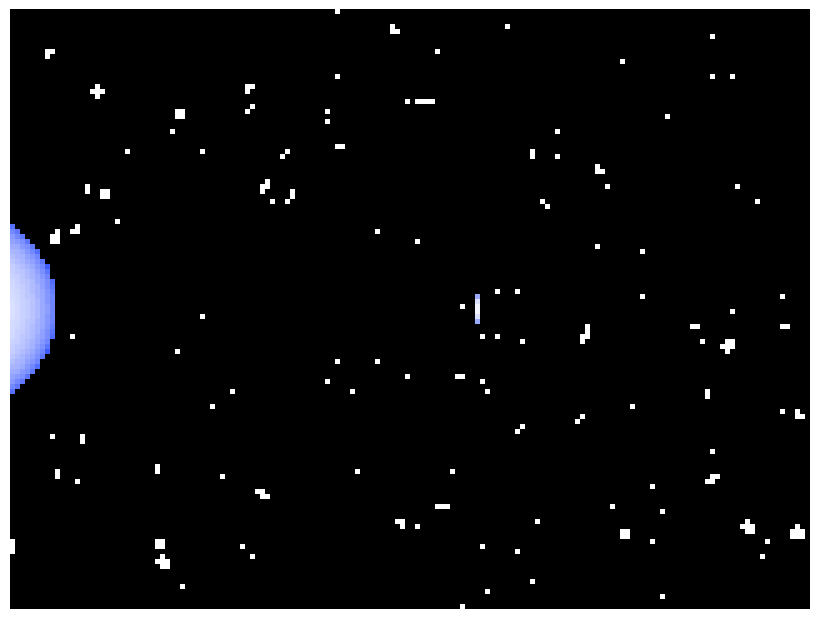

In [33]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
plt.subplots_adjust(bottom=0.25)

# Initialize the image
im = ax.imshow(np.clip(images[0],0,1), animated=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')
ax.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# # Create a slider axis and slider
# ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
# slider = Slider(ax_slider, 'Frame', 0, len(images) - 1, valinit=0, valstep=1)

# Update function for the animation
def update(frame):
    im.set_array(images[frame])
    return [im]

# Animation function
def animate(i):
    slider.set_val(i)
    return update(i)

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(images), interval=50, blit=True)
# Save the animation as an MP4 file
ani.save('animations/test.mp4', writer='ffmpeg', fps=10)
# # Display the animation in the notebook
HTML(ani.to_jshtml())
